In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import glob
import os
import seaborn as sns

%matplotlib inline

### Read Datasets

In [2]:
path = os.getcwd()
path = os.path.join(path,'dataset')

file_list = glob.glob(path+'/*csv')
names = [text.split("/")[-1].split(".")[0] for text in file_list]

for file,name in zip(file_list,names):
    df = pd.read_csv(file)
    globals()[f'{name}'] = df



### Exploratory Data Analysis (EDA)

Client Data

In [8]:
client_data.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [3]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [4]:
client_data.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056,152.786896,24.565121,24.562517,1.292346,189.264522,4.997809,18.135136,0.097152
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988,341.369366,20.231172,20.230280,0.709774,311.798130,1.611749,13.534743,0.296175
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.300000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,0.000000,14.280000,14.280000,1.000000,50.712500,4.000000,12.500000,0.000000
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378,37.395000,21.640000,21.640000,1.000000,112.530000,5.000000,13.856000,0.000000
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378,193.980000,29.880000,29.880000,1.000000,243.097500,6.000000,19.172500,0.000000
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,15042.790000,374.640000,374.640000,32.000000,24570.650000,13.000000,320.000000,1.000000


In [5]:
client_data["nb_prod_act"].unique()

array([ 2,  1,  3,  4,  5,  9,  6,  8, 32, 10])

plotting features toward churn to see if the relationship of the features are linear

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

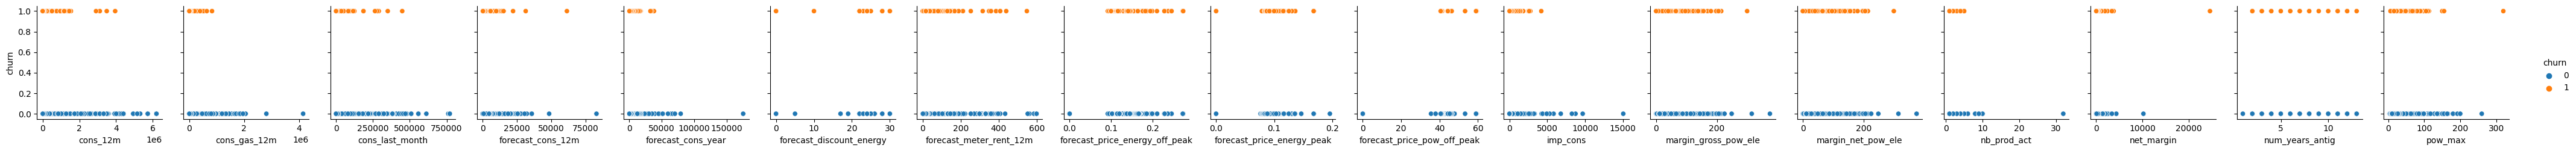

In [7]:
cont_features = client_data.select_dtypes(include=['int64','float64']).columns.tolist()
cont_features.remove("churn")
target = ['churn']

sns.pairplot(data = client_data, x_vars=cont_features,y_vars=target,hue='churn')
plt.show()

Consumption features might have information on customer's churn as it shows a linear relationship, however further analysis must be taken to ensure its effect to churn. Now let's explore price data and see how it relates with customer's churn

In [9]:
price_data.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


merging price data with the available customer id

In [11]:
customer_data = client_data[["id","churn"]]
price_df = customer_data.merge(price_data,on="id")

## Analysis

Understanding price distribution

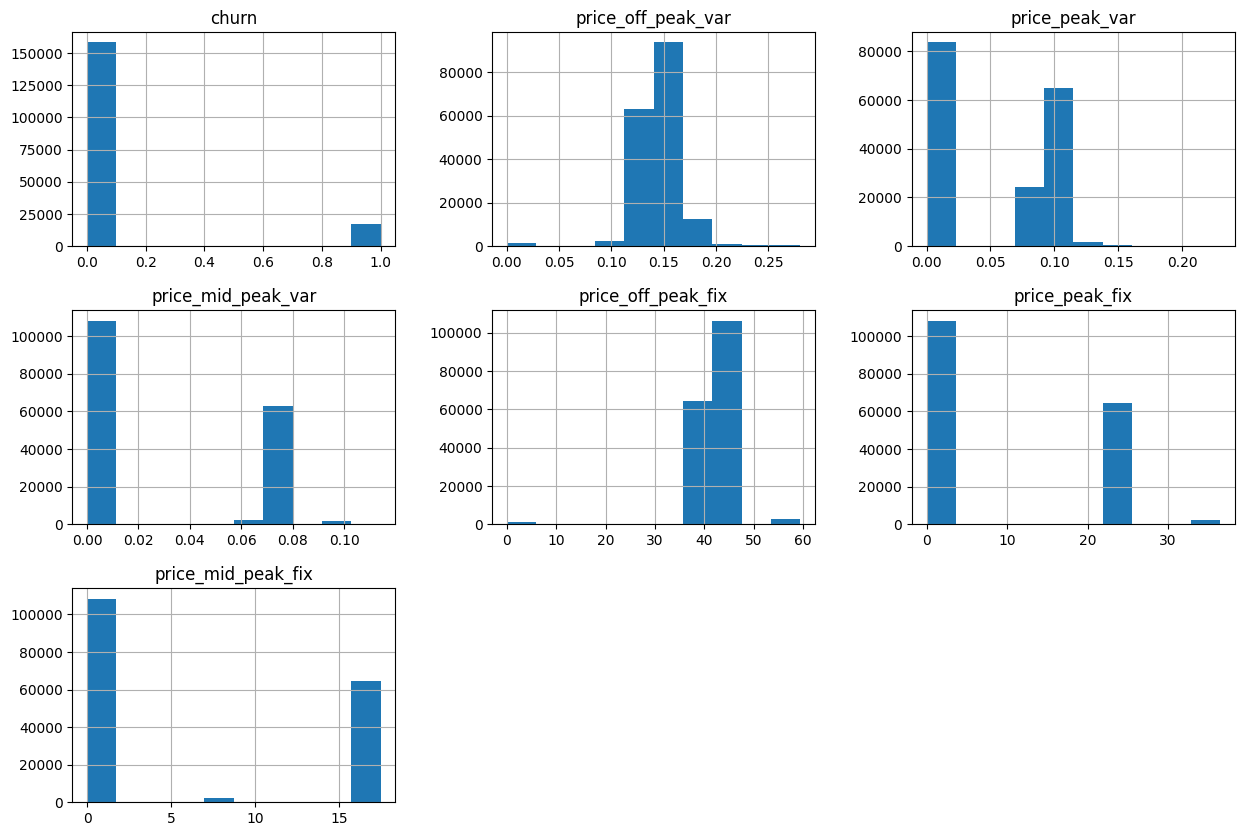

In [13]:
price_df.groupby(['id','price_date']).mean().hist(figsize=(15,10))
plt.show()

Data is skewed and imbalance

### Plotting energy and power price

In [31]:
churn_price = df_price[df_price["churn"] == 1].drop("id",axis=1).groupby(['price_date']).mean()
non_churn_price = df_price[df_price["churn"] == 0].drop("id",axis=1).groupby(['price_date']).mean()


Energy price

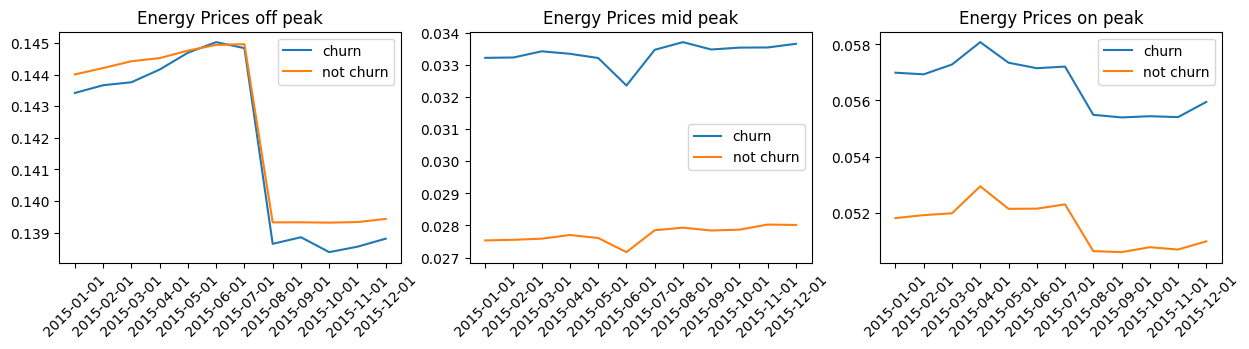

In [43]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.xticks(rotation=45)
plt.plot(churn_price["price_off_peak_var"])
plt.plot(non_churn_price["price_off_peak_var"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Energy Prices off peak")
plt.subplot(132)
plt.plot(churn_price["price_mid_peak_var"])
plt.plot(non_churn_price["price_mid_peak_var"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Energy Prices mid peak")
plt.subplot(133)
plt.xticks(rotation=45)
plt.plot(churn_price["price_peak_var"])
plt.plot(non_churn_price["price_peak_var"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Energy Prices on peak")
plt.show()

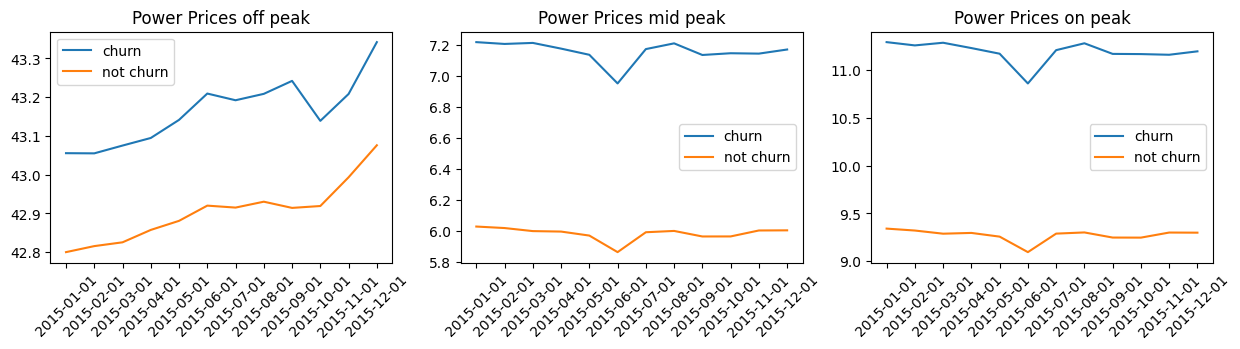

In [44]:
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.xticks(rotation=45)
plt.plot(churn_price["price_off_peak_fix"])
plt.plot(non_churn_price["price_off_peak_fix"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Power Prices off peak")
plt.subplot(132)
plt.plot(churn_price["price_mid_peak_fix"])
plt.plot(non_churn_price["price_mid_peak_fix"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Power Prices mid peak")
plt.subplot(133)
plt.xticks(rotation=45)
plt.plot(churn_price["price_peak_fix"])
plt.plot(non_churn_price["price_peak_fix"])
plt.legend(["churn","not churn"])
plt.xticks(rotation=45)
plt.title("Power Prices on peak")
plt.show()

Interesting findings on off peak energy prices where churn price is slightly lower than non-churn prices all the year, while on others all churn prices are always higher than non-churn prices. Furthermore, only off peak prices that has high difference between beginning and end of the year, while the others show relatively constant prices throughout the year